In [ ]:
!pip install matplotlib

In [1]:
#%%
from Modele_decodeur_maison import *

from Pipeline import *
from Trainer import * 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 10

# Images
# images = np.load("C:/Users/lucas/Desktop/train-resnet50-res4frelu.npy")

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau()
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head = 4 
num_encoder_layers = 2
num_decoder_layers = 2
dim_feedforward = 196
dropout = 0.1
activation = nn.Softmax
embedding_dim = 196

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation).to(device)

model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation).to(device)





DEBUT_DE_PHRASE
FIN_DE_PHRASE
TOKEN_VIDE
&@@
j
;@@
DEBUT_DE_PHRASE
FIN_DE_PHRASE
TOKEN_VIDE
&@@
j
ë
ë@@


Iteration : 0 data numéro : 200 en 62 ms par itération, moyenne loss 3.103253448009491
Iteration : 0 data numéro : 400 en 58 ms par itération, moyenne loss 2.241482873558998
Iteration : 1 data numéro : 200 en 113 ms par itération, moyenne loss 3.348298946470022
Iteration : 1 data numéro : 400 en 59 ms par itération, moyenne loss 1.3569769060611725
Iteration : 2 data numéro : 200 en 114 ms par itération, moyenne loss 1.3874220629408955


KeyboardInterrupt: 

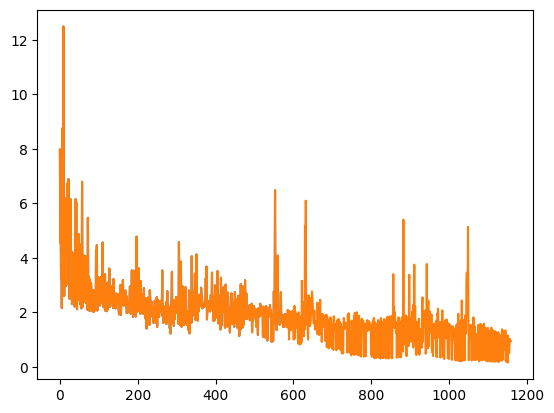

In [2]:

# Y=train_auto_encoding(model_fr,tokenized_fr)
# Y=train_auto_encoding(model_en,tokenized_en)
# Y= cycle_consistency_train(model_fr,model_en,tokenized_fr,tokenized_en)
mixed_train(model_fr,model_en,tokenized_fr,tokenized_en,200,50)



In [22]:
#%%
def tensor_to_sentence(output,inv_dic):
    result = [inv_dic[int(x)] for x in output]
    sentence = ""
    for word in result : 
        if word == "DEBUT_DE_PHRASE" :
            pass
        elif '@@' in word: 
            sentence+=word[:-2]
        elif word == "FIN_DE_PHRASE" :
            break 
        else :
            sentence+=word +" "
    return sentence

def traduit(model_A,model_B,data, inv_map):
    model_en.eval()
    model_fr.eval()
    output = torch.argmax(cycle_consistent_forward(model_A,model_B,data),dim = 2).T[j].T
    return tensor_to_sentence(output.view(-1),inv_map)

i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
data,target = get_batch(tokenized_en, i)

print("Phrase à traduire : \n" + tensor_to_sentence(target.T[j],inv_map_en)+ "\n Phrase traduite : \n "+ traduit(model_en,model_fr,data, inv_map_fr))


#%%

Phrase à traduire : 
rTOKEN_VIDE some TOKEN_VIDE 
 Phrase traduite : 
 deux TOKEN_VIDE eTOKEN_VIDE en TOKEN_VIDE garçon TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE lTOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE d&apos; TOKEN_VIDE a TOKEN_VIDE chiens TOKEN_VIDE un TOKEN_VIDE TOKEN_VIDE train TOKEN_VIDE en TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE à TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE ie TOKEN_VIDE sTOKEN_VIDE dans TOKEN_VIDE aux TOKEN_VIDE ballon TOKEN_VIDE bleu TOKEN_VIDE rier TOKEN_VIDE a TOKEN_VIDE gTOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE TOKEN_VIDE tTOKEN_VIDE dans TOKEN_VIDE s-TOKEN_VIDE 


In [26]:
i = np.random.randint(len(tokenized_en)//50)
j = np.random.randint(50)
data,target = get_batch(tokenized_en, i)
target
VALENTIN IL FAUT ABSOLUMENT QUE TU REGLE LE PROBLEME DU BATCHIFYER : LES DIMENSIONS SONT BONNES MAIS CEST NIMPORT QUOI LES DONENEES

tensor([[5830,    0,   29,  ..., 5832, 5832, 5832],
        [5832, 5832, 5832,  ..., 5830,    0,   10],
        [  32,    9,   39,  ..., 5832, 5832, 5832],
        ...,
        [5832, 5832, 5832,  ..., 5832, 5832, 5832],
        [5832, 5832, 5832,  ..., 5832, 5832, 5832],
        [5832, 5832, 5832,  ..., 5832, 5832, 5832]], device='cuda:0')

In [ ]:
import os

import s3fs
import pandas
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

val_features  = np.load(fs.open('tordjx/val-resnet50-res4frelu.npy'))
train_features  = np.load(fs.open('tordjx/train-resnet50-res4frelu.npy'))

In [ ]:
text_input = batchify(tokenized_fr[0],device)
image_input = torch.from_numpy(train_features[0]).type(torch.float32).to(device)
model_fr(text_input, True,image_input)